In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%cd ..

/jupyter-lab/repo/bigstar


# Import Modules

In [2]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"

import pickle
from collections import Counter
from functools import partial
from itertools import chain
from pathlib import Path
from typing import Dict, Iterable, Tuple

import joblib
import matplotlib.pyplot as plt
import mecab_ko as mecab
import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import scipy.special as sp
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from nlpaug.util import Action
from scipy.sparse import csr_matrix
from scipy.special import softmax
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from src.base_trainer import get_ckpt_path, get_model_hparams, get_run, load_model_state
from src.baseline.models import BaselineModel, BaselineModelWithMLAttention
from src.baseline.trainer import BaselineTrainerModel
from src.datasets import LotteQADataset, collate_fn
from src.eda import EDA
from src.utils import (
    delete_list_elements,
    filter_arguments,
    get_label_encoder,
    get_n_samples,
    get_num_batches,
)
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm.auto import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoTokenizer,
    MarianMTModel,
)
from transformers.models.marian.convert_marian_to_pytorch import (
    load_config_from_state_dict,
)
from transformers.tokenization_utils_base import PreTrainedTokenizerBase

from datasets import load_dataset

plt.rcParams["font.family"] = "NanumGothic"

# Functions

In [119]:
def predict(
    run_id, device=torch.device("cuda"), mode="train", aug_filename=None, df=None
):
    filename = f"mode={mode}-aug_filename={aug_filename}.joblib"
    run = get_run(log_dir="./logs", run_id=run_id)

    filepath = os.path.join(
        "./logs", run.info.experiment_id, run_id, "artifacts", filename
    )

    if not os.path.exists(filepath) or df is not None:
        ckpt_path = get_ckpt_path(log_dir="./logs", run_id=run_id, load_best=True)
        model_hparams = get_model_hparams(
            "./logs", run_id, BaselineTrainerModel.MODEL_HPARAMS
        )
        le = get_label_encoder("./cache/label_encoder.joblib")

        model_cls = (
            BaselineModel
            if model_hparams["model_name"] == "Baseline"
            else BaselineModelWithMLAttention
        )

        model = model_cls(
            num_labels=len(le.classes_), **filter_arguments(model_hparams, model_cls)
        )

        load_model_state(model, ckpt_path, substitution=(r"^model\.", ""))

        test_dataset = LotteQADataset(mode=mode, aug_filename=aug_filename, df=df)
        tokenizer = AutoTokenizer.from_pretrained(
            model_hparams["pretrained_model_name"]
        )
        test_dataloader = DataLoader(
            test_dataset,
            batch_size=16,
            pin_memory=True,
            num_workers=4,
            collate_fn=partial(
                collate_fn,
                tokenizer=tokenizer,
                le=le,
                max_length=model_hparams["max_length"],
            ),
        )

        model.to(device)
        model.eval()
        logits = []

        for batch_x, batch_y in tqdm(test_dataloader):
            batch_x = {k: v.to(device) for k, v in batch_x.items()}
            with torch.no_grad(), torch.cuda.amp.autocast():
                outputs = model(batch_x)
            logits.append(outputs.cpu())

        logits = np.concatenate(logits)
        predictions = logits.argmax(axis=-1)

        gt = le.transform(test_dataset.y)
        f1_micro = f1_score(gt, predictions, average="micro")
        prec_macro, recall_macro, f1_macro, support = precision_recall_fscore_support(
            gt,
            predictions,
            average="macro",
            zero_division=0,
        )
        (
            prec_weighted,
            recall_weighted,
            f1_weighted,
            _,
        ) = precision_recall_fscore_support(
            gt,
            predictions,
            average="weighted",
            zero_division=0,
        )
        prec, recall, f1, _ = precision_recall_fscore_support(
            gt, predictions, average=None, zero_division=0
        )

        matrix = confusion_matrix(gt, predictions)

        df = pd.DataFrame(
            {
                "intent": le.classes_,
                "support": matrix.sum(axis=-1),
                "# to tp": np.diag(matrix),
                "# of predicted": matrix.sum(axis=0),
            }
        )

        result = {
            "df": df,
            "matrix": matrix,
            "f1_micro": f1_micro,
            "prec_macro": prec_macro,
            "recall_macro": recall_macro,
            "f1_macro": f1_macro,
            "prec_weighted": prec_weighted,
            "recall_weighted": recall_weighted,
            "f1_weighted": f1_weighted,
            "prec": prec,
            "recall": recall,
            "f1": f1,
            "gt": gt,
            "predictions": predictions,
            "logits": logits,
        }
        if df is None:
            joblib.dump(result, filepath)
    else:
        result = joblib.load(filepath)

    print(f"f1        (micro): {result['f1_micro']:.4f}")
    print(f"prec      (macro): {result['prec_macro']:.4f}")
    print(f"recall    (macro): {result['recall_macro']:.4f}")
    print(f"f1        (macro): {result['f1_macro']:.4f}")
    print(f"prec   (weighted): {result['prec_weighted']:.4f}")
    print(f"recall (weighted): {result['recall_weighted']:.4f}")
    print(f"f1     (weighted): {result['f1_weighted']:.4f}")

    return result


def plot_label_distribution(df, key="인텐트", columns=None, figsize=(12, 4), **kwargs):
    value_counts = df[key].value_counts()
    if columns is not None:
        value_counts = value_counts.loc[columns]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set(**kwargs)
    sns.barplot(x=value_counts.index, y=value_counts.to_numpy(), ax=ax)


def get_result_df(result, data_df, le):
    gt = result["gt"]
    predictions = result["predictions"]
    logits = result["logits"]

    df = data_df.copy()
    probs = sp.softmax(logits.astype(np.float32), axis=-1)
    ranks = np.where(probs.argsort(axis=-1)[..., ::-1] == gt[..., None])[1] + 1

    df["prediction"] = le.classes_[predictions]
    df["probs (gt)"] = probs[(np.arange(len(gt)), gt)]
    df["probs (pred)"] = probs.max(axis=-1)
    df["rank (gt)"] = ranks

    return df

In [ ]:
train_df.copy()

# Load Dataset

In [120]:
train_df = LotteQADataset().df
val_df = LotteQADataset(mode="val").df
test_df = LotteQADataset(mode="test").df
le = get_label_encoder("cache/label_encoder.joblib")
mlb = get_label_encoder("cache/label_encoder_mlb.joblib", is_multilabel=True)

# Set Some Variables

In [5]:
device = torch.device("cuda:0")

# Analysis

In [4]:
results = joblib.load("outputs/pred.joblib")
results1 = results[0]  # Baseline prediction (test set)
results2 = results[1]  # Prediction trained with augmented train+back.v9 (test set)
results3 = results[2]  # Prediction trained with original (back.v1)

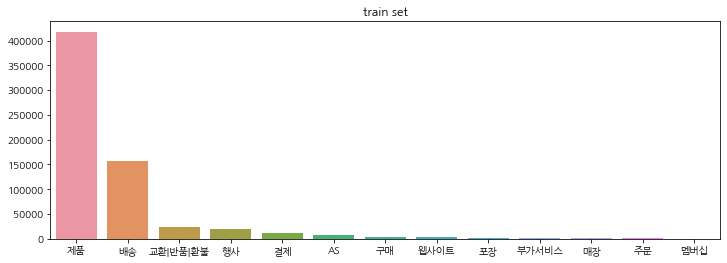

In [39]:
plot_label_distribution(train_df, title="train set")

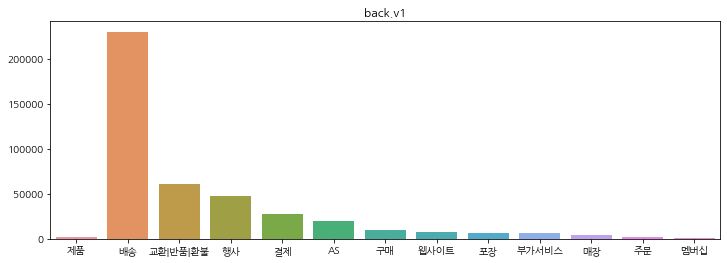

In [40]:
back_v1_df = pd.read_csv("data/back.v1.csv")
columns = train_df['인텐트'].value_counts().index
plot_label_distribution(back_v1_df, columns=columns, title="back.v1")

In [41]:
train_back_v10_results = predict(run_id="d44ead9cc64f42a480fa728ce63025a0", mode="test")
train_back_v10_results["df"].to_excel("outputs/predictions.xlsx", index=False)

  0%|          | 0/5301 [00:00<?, ?it/s]

f1        (micro): 0.9306
prec      (macro): 0.6867
recall    (macro): 0.5975
f1        (macro): 0.6195
prec   (weighted): 0.9276
recall (weighted): 0.9306
f1     (weighted): 0.9281


In [42]:
# Baseline
train_results = predict(run_id="d44ead9cc64f42a480fa728ce63025a0", mode="train")

  0%|          | 0/40813 [00:00<?, ?it/s]

f1        (micro): 0.9333
prec      (macro): 0.7475
recall    (macro): 0.6330
f1        (macro): 0.6575
prec   (weighted): 0.9299
recall (weighted): 0.9333
f1     (weighted): 0.9301


In [87]:
# BaselineWithMLAttention
train_results2 = predict(run_id="f19847f8ba794b2492f184ee8f26ba9e", mode="train")

  0%|          | 0/40813 [00:00<?, ?it/s]

f1        (micro): 0.9398
prec      (macro): 0.7373
recall    (macro): 0.6057
f1        (macro): 0.6461
prec   (weighted): 0.9346
recall (weighted): 0.9398
f1     (weighted): 0.9351


In [103]:
logits = (train_results["logits"] + train_results2["logits"]) / 2
gt = train_results["gt"]
predictions = logits.argmax(axis=-1)
matrix = confusion_matrix(train_results["gt"], predictions)

f1_micro = f1_score(gt, predictions, average="micro")
prec_macro, recall_macro, f1_macro, support = precision_recall_fscore_support(
    gt,
    predictions,
    average="macro",
    zero_division=0,
)
prec_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    gt,
    predictions,
    average="weighted",
    zero_division=0,
)
prec, recall, f1, _ = precision_recall_fscore_support(
    gt, predictions, average=None, zero_division=0
)

print(f"f1        (micro): {f1_micro:.4f}")
print(f"prec      (macro): {prec_macro:.4f}")
print(f"recall    (macro): {recall_macro:.4f}")
print(f"f1        (macro): {f1_macro:.4f}")
print(f"prec   (weighted): {prec_weighted:.4f}")
print(f"recall (weighted): {recall_weighted:.4f}")
print(f"f1     (weighted): {f1_weighted:.4f}")

pd.DataFrame(
    {
        "intent": le.classes_,
        "support": matrix.sum(axis=-1),
        "# to tp": np.diag(matrix),
        "# of predicted": matrix.sum(axis=0),
    }
)

f1        (micro): 0.9392
prec      (macro): 0.7374
recall    (macro): 0.6216
f1        (macro): 0.6594
prec   (weighted): 0.9345
recall (weighted): 0.9392
f1     (weighted): 0.9351


,intent,support,# to tp,# of predicted
0,AS,8261,6511,8207
1,결제,11332,4220,6175
2,교환|반품|환불,23707,20773,24559
3,구매,4088,2265,2679
4,매장,2059,1522,1689
5,멤버십,404,164,233
6,배송,156965,150736,160571
7,부가서비스,2578,1385,1815
8,웹사이트,3089,482,860
9,제품,417927,406276,423079


In [157]:
# BaselineWithMLAttention + Label Smoothing
test_results3 = predict(run_id="0ef0a6f1a5fc45b88ebf64d92dd6e8e6", mode="test")

  0%|          | 0/5301 [00:00<?, ?it/s]

f1        (micro): 0.9374
prec      (macro): 0.7294
recall    (macro): 0.5675
f1        (macro): 0.6161
prec   (weighted): 0.9324
recall (weighted): 0.9374
f1     (weighted): 0.9327


In [175]:
# BaselineWithMLAttention + Label Smoothing
train_results3 = predict(run_id="0ef0a6f1a5fc45b88ebf64d92dd6e8e6", mode="train")

  0%|          | 0/40813 [00:00<?, ?it/s]

f1        (micro): 0.9436
prec      (macro): 0.7666
recall    (macro): 0.6061
f1        (macro): 0.6580
prec   (weighted): 0.9388
recall (weighted): 0.9436
f1     (weighted): 0.9390


In [256]:
# BaselineWithMLAttention + Label Smoothing over augmented data by backtranslation
back_v1_results = predict(run_id="0ef0a6f1a5fc45b88ebf64d92dd6e8e6", aug_filename="back.v1.csv")

  0%|          | 0/26514 [00:00<?, ?it/s]

f1        (micro): 0.5301
prec      (macro): 0.4740
recall    (macro): 0.3239
f1        (macro): 0.3150
prec   (weighted): 0.7630
recall (weighted): 0.5301
f1     (weighted): 0.6068


In [259]:
pd.concat([back_v1_results['df'], pd.DataFrame({'f1': back_v1_results['f1']})], axis=1)

,intent,support,# to tp,# of predicted,f1
0,AS,19917,8034,13906,0.475061
1,결제,27632,6084,14703,0.287422
2,교환|반품|환불,61100,19546,24351,0.457479
3,구매,9562,2501,5533,0.331368
4,매장,4310,1639,4213,0.384606
5,멤버십,960,80,211,0.136635
6,배송,229806,167957,194632,0.791432
7,부가서비스,6005,899,1373,0.243697
8,웹사이트,7947,294,1524,0.062084
9,제품,1654,1572,142512,0.021808


In [183]:
# Count incorrect predictions
results = back_v1_results
incorrect = np.where(results['gt'] != results['predictions'])[0]
pd.DataFrame(train_df.iloc[incorrect]['인텐트'].value_counts())

,인텐트
제품,7967
결제,7052
배송,6542
교환|반품|환불,3031
웹사이트,2642
행사,2338
구매,1935
AS,1930
부가서비스,1251
주문,760


In [232]:
df = train_df.loc[incorrect]
probs = sp.expit(train_results3["logits"][incorrect].astype(np.float32)).max(
    axis=-1
)
df["prediction"] = le.classes_[train_results3["predictions"][incorrect]]
df["probs"] = probs
df[df["probs"] >= 0.8]

,발화문,인텐트,prediction,probs
126,혹시 세로 길이 연장 가능한가요?,AS,제품,0.893867
212,스냅은 상품당 3개 오는 건가요?,행사,제품,0.877267
246,기장을 33CM 정도로 더 짧게 하고 싶은데 가능한가요?,구매,제품,0.871912
335,설치하려면 벽 뚫어야 하나요?,부가서비스,제품,0.830732
342,이 커튼봉도 같이 주문하면 되는 건가요?,구매,제품,0.866472
...,...,...,...,...
652538,116CM 인데 어떻게 주문해야 할지요?,결제,제품,0.833460
652540,길이 225CM 인데 구매 가능한가요?,결제,제품,0.817429
652542,폭이 116이면 어케 구매 하나요?,결제,제품,0.833325
652899,2센티220 보슬이 10개 5센티 80까슬이 2개 맞죠?,결제,제품,0.903465


In [250]:
probs = sp.expit(train_results3['logits'].astype(np.float32))
prob = probs[61703]
for l, p in zip(le.classes_[prob.argsort()[::-1]], prob[prob.argsort()[::-1]]):
    print(f"{l}: {p:.4f}")

제품: 0.5833
교환|반품|환불: 0.2144
주문: 0.0981
구매: 0.0380
결제: 0.0180
배송: 0.0078
행사: 0.0062
웹사이트: 0.0061
AS: 0.0059
포장: 0.0058
부가서비스: 0.0058
매장: 0.0058
멤버십: 0.0058


In [21]:
train_results = predict(
    run_id="ca49adf0b85642a5bf22d86cfbe3782a", device=device, mode="train"
)

  0%|          | 0/40813 [00:00<?, ?it/s]

f1        (micro): 0.9448
prec      (macro): 0.7393
recall    (macro): 0.6571
f1        (macro): 0.6845
prec   (weighted): 0.9408
recall (weighted): 0.9448
f1     (weighted): 0.9415


In [81]:
df = train_results["df"]
df["precision"] = train_results["prec"]
df["recall"] = train_results["recall"]
df["f1"] = train_results["f1"]
df

,intent,support,# to tp,# of predicted,precision,recall,f1
0,AS,8261,6700,8297,0.807521,0.811040,0.809276
1,결제,11332,4558,6568,0.693971,0.402224,0.509274
2,교환|반품|환불,23707,21014,24482,0.858345,0.886405,0.872149
3,구매,4088,2521,3005,0.838935,0.616683,0.710842
4,매장,2059,1656,1835,0.902452,0.804274,0.850539
5,멤버십,404,160,232,0.689655,0.396040,0.503145
6,배송,156965,150139,157537,0.953040,0.956513,0.954773
7,부가서비스,2578,1728,2473,0.698746,0.670287,0.684221
8,웹사이트,3089,752,1263,0.595408,0.243444,0.345588
9,제품,417927,408158,423804,0.963082,0.976625,0.969806


In [78]:
gt = train_results["gt"]
predictions = train_results["predictions"]
logits = train_results["logits"]

incorrect = np.where(gt != predictions)[0]

df = train_df.loc[incorrect]
probs = sp.softmax(logits[incorrect].astype(np.float32), axis=-1)
ranks = np.where(probs.argsort(axis=-1)[..., ::-1] == gt[incorrect, None])[1] + 1

df["prediction"] = le.classes_[predictions[incorrect]]
df["probs (gt)"] = probs[(np.arange(len(incorrect)), gt[incorrect])]
df["probs (pred)"] = probs.max(axis=-1)
df["rank (gt)"] = ranks
df[(df["인텐트"] == "주문") & (df["probs (pred)"] > 0)]

,발화문,인텐트,prediction,probs (gt),probs (pred),rank (gt)
6,주문 가능할까요?,주문,제품,0.217310,0.537848,2
44,제가 잘못 이해하고 주문한 걸까요?,주문,결제,0.065040,0.544570,4
239,"아이보리좌, 우각각 270으로 주문했는데요 이렇게 하는 게 맞는 것인가요?",주문,제품,0.221664,0.652782,2
272,작년 12월 제품 주문하여 아주 잘 사용하고 있습니다 대형 하나만 필요한데 한 개만...,주문,제품,0.109709,0.597731,3
293,두 장으로 가능하까요 아님네 장하는 게 졸까요?,주문,제품,0.063245,0.730189,3
...,...,...,...,...,...,...
61080,방금 핑크로 주문했는데요블루로 바꿀 수 있나요?,주문,제품,0.169609,0.527558,3
61131,두 세트 주문했는데 그럼 100개 아닌가요?,주문,배송,0.021442,0.485875,4
61425,프레임만 주문 가능한지요?,주문,제품,0.070103,0.634659,3
61703,그린주문했는데 혹시 핑크색으로 변경 가능한가요?,주문,제품,0.187044,0.549752,3


In [210]:
df[df['인텐트'] == '주문']['prediction'].value_counts()

제품          680
배송           29
결제           27
행사            7
AS            6
구매            5
교환|반품|환불      4
웹사이트          2
Name: prediction, dtype: int64

# Backtranslation

In [9]:
ridx = np.random.choice(len(train_df), size=100, replace=False)
filtered_df = train_df.loc[ridx]

In [11]:
filtered_df.to_csv("data/train_sampling.csv", index=False)

In [63]:
%%time

augmented_data = joblib.load("outputs/backtranslation/back_translated.v4.joblib")
data = joblib.load("cache/ccf8721efb9be116be1cff94d0b2b5b1/data.joblib")

print(f"# of augmented data: {len(augmented_data):,}")
print(f"# of remaining train set: {len(data['xs']):,}")

pd.DataFrame(pd.DataFrame({"intent": data["ys"]})["intent"].value_counts())

# of augmented data: 458,451
# of remaining train set: 468,245
CPU times: user 11.2 s, sys: 132 ms, total: 11.3 s
Wall time: 11.2 s


,intent
제품,417905
배송,50340


In [82]:
augmented_data = joblib.load("outputs/backtranslation/back_translated.v4.joblib")
texts, labels = zip(*augmented_data)
df = pd.DataFrame({"발화문": texts, "인텐트": labels})
df['발화문'] = df['발화문'].apply(lambda t: np.nan if t.strip() == "" else t)
df = df.dropna().drop_duplicates().reset_index(drop=True)
df.to_csv("data/back.v11.csv", index=False)

In [83]:
back_v11_results = predict(
    run_id="ca49adf0b85642a5bf22d86cfbe3782a", device, aug_filename="back.v11.csv"
)

  0%|          | 0/28653 [00:00<?, ?it/s]

f1        (micro): 0.5530
prec      (macro): 0.4860
recall    (macro): 0.3495
f1        (macro): 0.3301
prec   (weighted): 0.7691
recall (weighted): 0.5530
f1     (weighted): 0.6252


In [117]:
probs = sp.softmax(back_v11_results["logits"].astype(np.float32), axis=-1).max(axis=-1)
predictions = back_v11_results["predictions"]
gt = back_v11_results["gt"]
correct = np.where(gt == predictions)[0]
tmp_df = pd.concat([df, pd.DataFrame({"prob": probs})], axis=1)
filtered_df = tmp_df.loc[correct]
filtered_df = filtered_df[filtered_df["prob"] >= 0.7]

merged_df = (
    pd.concat([train_df, filtered_df[["발화문", "인텐트"]]])
    .dropna()
    .drop_duplicates()
    .reset_index(drop=True)
)
merged_df.to_csv("data/train+back.v11.csv", index=False)

---

# GPT2

## Load Model & Tokenizer

In [6]:
pretrained_model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name,
    bos_token="</s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    mask_token="<mask>",
)
model = AutoModelForCausalLM.from_pretrained(pretrained_model_name)
_ = model.to(device)

In [7]:
run_id = "ff7662944c014a1d9d774fd8e7edff8b"
ckpt_path = get_ckpt_path(log_dir="./logs", run_id=run_id)
load_model_state(model, ckpt_path, substitution=(r"^model\.", ""))

## Preprocessing Data

In [227]:
%%time

# <unused1> ~ <unused13>
label_token_id_map = {le.classes_[i]: 10 + i for i in range(le.classes_.size)}

# <unused0>
sep_token_id = 9

os.environ["TOKENIZERS_PARALLELISM"] = "true"

inputs = tokenizer(train_df["발화문"].tolist())

y = train_df["인텐트"].tolist()
input_ids = list(
    chain(
        *[
            [label_token_id_map[y[i]]] + [sep_token_id] + ids + [tokenizer.eos_token_id]
            for i, ids in enumerate(inputs["input_ids"])
        ]
    )
)

block_size = 128
total_length = len(input_ids)
num_blocks = get_num_batches(block_size, total_length)
input_ids = [
    input_ids[i * block_size : (i + 1) * block_size] for i in range(num_blocks)
]
input_ids[-1].extend([tokenizer.pad_token_id] * (block_size - len(input_ids[-1])))
input_ids = torch.tensor(input_ids)
attention_mask = torch.ones(len(result), block_size, dtype=torch.long)
attention_mask[-1, -num_pads:] = 0

CPU times: user 1min 25s, sys: 4.57 s, total: 1min 29s
Wall time: 34 s


In [217]:
batch_size = 8
batch_input_ids = torch.tensor(input_ids[:batch_size])
batch_attention_mask = attention_mask[:batch_size]

output = model(
    input_ids=batch_input_ids.to(device),
    attention_mask=batch_attention_mask.to(device),
    labels=batch_input_ids.to(device),
)

---

In [16]:
for i, label in enumerate(le.classes_, start=1):
    print(f"{label}: <unused{i}>")

AS: <unused1>
결제: <unused2>
교환|반품|환불: <unused3>
구매: <unused4>
매장: <unused5>
멤버십: <unused6>
배송: <unused7>
부가서비스: <unused8>
웹사이트: <unused9>
제품: <unused10>
주문: <unused11>
포장: <unused12>
행사: <unused13>


In [88]:
train_df[train_df['인텐트'] == '부가서비스']

,발화문,인텐트
217,빨리 주문해야 담주 안에 설치할 수 있지 않을까요?,부가서비스
226,드레스룸의 작은 창에 설치하고 싶은데요 주문 가능할까요?,부가서비스
335,설치하려면 벽 뚫어야 하나요?,부가서비스
496,롯데 상품 4 - 5개 구입 예정인데.설치가 눙할까요?,부가서비스
749,봉 설치 부자재도 오는 거 맞지요?,부가서비스
...,...,...
412373,윈도우 10 설치 비용은 얼마로 책정되었나요?,부가서비스
412436,에어컨 수거서비스 신청시 비용 발생해요?,부가서비스
412437,이 매장에서 에어컨 샀는데 기존 에어컨 수거는 무료인가요?,부가서비스
412448,에어컨 설치하러 10월 28일에 오시는 거죠?,부가서비스


In [101]:
text = ["<unused8><unused0>"]
inputs = tokenizer(text, return_tensors="pt")
output = model.generate(
    inputs["input_ids"].to(device),
    max_length=100,
    do_sample=True,
    # num_beams=5,
    # num_beam_groups=2,
    top_k=50,
    top_p=0.95,
    # typical_p=0.5,
    num_return_sequences=5,
    # repetition_penalty=2.0,
    # temperature=0.7,
    early_stopping=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
)
sentences = tokenizer.batch_decode(output, skip_special_tokens=True)

for i, sentence in enumerate(sentences):
    print(f"{i}:\n{sentence}\n")

0:
혹시 배송 중일 시에 배송이 어려울까요?

1:
혹시 지금 결제하고 바로 설치 가능한지요?

2:
혹시 위의 사진대로 화이트+화이트로 변경 가능한가요?

3:
빠른 처리 부탁드리구요. 상품 구매 목록에 W3 화이트는 현재 품절로 확인되는데 교환 가능한가요?

4:
혹시 오늘 배송해 주시는지요?



In [8]:
aug_data = joblib.load("outputs/gpt2_aug_data.joblib")

In [10]:
%%time
n_samples = 100
label_token_map = {le.classes_[i]: f"<unused{i+1}>" for i in range(le.classes_.size)}
sep_token = "<unused0>"
max_samples = 500000

# aug_data = set()
with tqdm(total=max_samples) as pbar:
    pbar.update(len(aug_data))

    while len(aug_data) < max_samples:
        for label in le.classes_:
            text = [label_token_map[label] + sep_token]
            inputs = tokenizer(text, return_tensors="pt")
            output = model.generate(
                inputs["input_ids"].to(device),
                max_length=100,
                do_sample=True,
                # num_beams=5,
                # num_beam_groups=2,
                top_k=50,
                top_p=0.95,
                # typical_p=0.5,
                num_return_sequences=n_samples,
                # repetition_penalty=2.0,
                # temperature=0.7,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                bos_token_id=tokenizer.bos_token_id,
            )
            sentences = tokenizer.batch_decode(output, skip_special_tokens=True)
            num_aug_data = len(aug_data)
            aug_data.update(set(zip(sentences, [label] * len(sentences))))
            pbar.update(len(aug_data) - num_aug_data)

xs, ys = zip(*aug_data)
df = pd.DataFrame({"발화문": xs, "인텐트": ys})
df

  0%|          | 0/500000 [00:00<?, ?it/s]

CPU times: user 3h 13min, sys: 17min 23s, total: 3h 30min 23s
Wall time: 3h 30min 12s


,발화문,인텐트
0,빠른 처리 부탁드리며 오늘 배송 예약 햇는데 혹시 오늘 출고되는 건가요?,AS
1,오늘 샀는데 한 박스에 더 담겨 오나요?,결제
2,빨리 주문해서 받으셔서 설치 잘 부탁드립니다. 배송비도 가능한지요?,부가서비스
3,지금 구매하고 차후 사은품도 받을 수 있나요?,행사
4,혹시 저희가 배송해주시는 칫솔모 따로 구매해야 하나요?,매장
...,...,...
500332,11번 구매 햇는데 옵션 번호로 주문하면 되는 건가요?,주문
500333,오늘 혹시 워머세트 선물포장하시는 건가요?,제품
500334,혹시 지금 결제한 건도 취소 가능한지요?,배송
500335,혹시 윈도우 탑재 제품 구매 시 기존 브라우저로 인한 문제 및 기기 이상 있는 건 ...,매장


In [11]:
joblib.dump(aug_data, "outputs/gpt2_aug_data.v2.joblib")

['outputs/gpt2_aug_data.v2.joblib']

In [13]:
aug_result = predict(run_id="ca49adf0b85642a5bf22d86cfbe3782a", device=device, df=df)
result_df = get_result_df(aug_result, df, le)
result_df

  0%|          | 0/31272 [00:00<?, ?it/s]

f1        (micro): 0.1597
prec      (macro): 0.1503
recall    (macro): 0.1585
f1        (macro): 0.1218
prec   (weighted): 0.1533
recall (weighted): 0.1597
f1     (weighted): 0.1204


,발화문,인텐트,prediction,probs (gt),probs (pred),rank (gt)
0,빠른 처리 부탁드리며 오늘 배송 예약 햇는데 혹시 오늘 출고되는 건가요?,AS,배송,0.000069,0.998635,5
1,오늘 샀는데 한 박스에 더 담겨 오나요?,결제,포장,0.001455,0.842569,6
2,빨리 주문해서 받으셔서 설치 잘 부탁드립니다. 배송비도 가능한지요?,부가서비스,배송,0.072400,0.915355,2
3,지금 구매하고 차후 사은품도 받을 수 있나요?,행사,행사,0.936409,0.936409,1
4,혹시 저희가 배송해주시는 칫솔모 따로 구매해야 하나요?,매장,제품,0.000098,0.960782,10
...,...,...,...,...,...,...
500332,11번 구매 햇는데 옵션 번호로 주문하면 되는 건가요?,주문,제품,0.027748,0.590100,4
500333,오늘 혹시 워머세트 선물포장하시는 건가요?,제품,포장,0.002578,0.992635,2
500334,혹시 지금 결제한 건도 취소 가능한지요?,배송,결제,0.005875,0.800432,3
500335,혹시 윈도우 탑재 제품 구매 시 기존 브라우저로 인한 문제 및 기기 이상 있는 건 ...,매장,제품,0.000031,0.998391,9


In [14]:
correct = np.where(aug_result['gt'] == aug_result['predictions'])[0]
print(f"# of tp: {len(correct):,}")
correct_df = result_df.loc[correct]
pd.DataFrame(correct_df['인텐트'].value_counts())

# of tp: 79,920


,인텐트
제품,28955
배송,17265
행사,8545
포장,4824
매장,3621
AS,3363
멤버십,3341
결제,2727
부가서비스,2639
교환|반품|환불,2087


In [15]:
correct_df.to_csv("data/gpt2_data.v2.csv", index=False)

In [16]:
merged_df = pd.concat([train_df, correct_df[['발화문', '인텐트']]]).drop_duplicates().dropna()
merged_df.to_csv("data/train+gpt2.v2.csv", index=False)

In [121]:
train_result = predict(run_id='ca49adf0b85642a5bf22d86cfbe3782a', device=device)
train_result_df = get_result_df(train_result, train_df, le)

f1        (micro): 0.9448
prec      (macro): 0.7393
recall    (macro): 0.6571
f1        (macro): 0.6845
prec   (weighted): 0.9408
recall (weighted): 0.9448
f1     (weighted): 0.9415


In [33]:
tmp_df = train_result_df
tmp_df[tmp_df['인텐트'] == '주문']['prediction'].value_counts()

제품          680
배송           29
결제           27
행사            7
AS            6
구매            5
교환|반품|환불      4
웹사이트          2
Name: prediction, dtype: int64

---

In [159]:
rng = np.random.default_rng(1234)
n_samples = get_n_samples(train_df["인텐트"].to_numpy()).min().item()
indices = []

for label in le.classes_:
    df = train_df[train_df["인텐트"] == label]
    idx = df.index.to_numpy()
    idx = rng.choice(idx, size=n_samples, replace=False)
    indices.append(idx)

indices = np.concatenate(indices)
tmp_df = (
    train_df.loc[indices]
    .sample(frac=1.0, random_state=rng.bit_generator)
    .dropna()
    .drop_duplicates()
    .reset_index(drop=True)
)

tmp_df.to_csv("data/train_sample.csv", index=False)